# Machine Learning Engineer Nanodegree

## Capstone Project

Daniel Bank

December 3rd, 2018

# Overview

## Photometric LSST Astronomical Time Series Classification Challenge

The Large Synoptic Survey Telescope (LSST), currently under construction in the Atacama desert of Chile, is the most awesome telescope that mankind will have built thus far in history.  It features an 8.4m mirror, 3.2 gigapixel camera, and 6.5m effective aperture [[1](#references)].  Every night, it will gather between 20 and 40 TB of image data of the southern sky.  While sifting through that much data to identify cosmological objects would be impractical for humans, it is a perfect use case for machine learning.

In preparation for the massive amounts of observations that will come from the LSST, an open data competition has been launched on [Kaggle](https://www.kaggle.com) called the Photometric LSST Astronomical Time Series Classification Challenge ([PLAsTiCC](https://www.kaggle.com/c/PLAsTiCC-2018)).  The goal of the challenge is to correctly classify time-varying cosmological objects in simulated astronomical time-series data similar to the data that the LSST will generate.

I first became aware of this challenge while browsing the Kaggle competitions.  My personal interest in astronomy stems partly from my background as a Physics major but more so from son, Arthur, who loves everything about the night sky.  He has taught me to really appreciate the beauty of the cosmos.

## Problem Statement

PLAsTiCC includes a 60 MB training dataset of labeled data.  That is to say, the sources in the training data have known classifications that our model can be trained on.  Our trained model must then for every object i in the test dataset predict the probabilities of it belonging to class j.  For any object, these probabilities should sum to 1.

![Classification Probabilities](https://github.com/danielbank/PLAsTiCC/blob/master/.github/probability_equations.png?raw=true)

The largest `Pij` for object i is what our model will finally classify it as.  These predicted classifications can then be compared to the actual classifications for the objects in the test dataset to obtain an accuracy for our model.

Our objective is to beat the accuracy of the PLAsTiCC Astronomy Classification Demo Classifier.

## Evaluation Metrics

The PLAsTiCC team has provided a demo classifier for the challenge [[2](#references)].  The performance of the demo classifier on the test data can be visualized in the following confusion matrix:

![Naive Classifier Confusion Matrix](https://github.com/danielbank/PLAsTiCC/blob/master/.github/naive_classifier_confusion_matrix.png?raw=true)

In this matrix, we can see the model's predicted labels versus the true labels for the test set.  Ideally, this confusion matrix would be the Identity matrix, with all values along the diagonal being 1 and everything else being 0.  That would mean that the model predicted the correct label 100% of the time.

When designing my classifier, I will generate a similar confusion matrix so that my results can be objectively compared to the demo classifier.  My objective is to have an average prediction accuracy per label that is higher than the demo classifier's accuracy of 0.518 (see calculation below):

```
(1.00 + 0.06 + 0.31 + 0.23 + 0.02 +
 0.19 + 0.86 + 0.76 + 0.34 + 0.59 +
 0.96 + 0.70 + 0.36 + 0.87) / 14
= 0.518
```

# Analysis

In [1]:
# Import Libraries and Configure Notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from itertools import chain
import cesium.featurize as featurize
from gatspy.periodic import LombScargleMultiband, LombScargleMultibandFast
import pdb
import gc
import tensorflow as tf
import keras.backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Lambda
from keras.layers import GRU, Dense, Activation, Dropout, concatenate, Input, BatchNormalization
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from collections import Counter
import pickle
from tensorflow.python.client import timeline
import re
import time
from operator import itemgetter

%matplotlib inline
sns.set_style('whitegrid')
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)

Using TensorFlow backend.


In [2]:
# Load Training Data

train_series = pd.read_csv('../input/training_set.csv')
train_metadata = pd.read_csv('../input/training_set_metadata.csv')

## Data Exploration

One interesting observation is that classes in the training data set divide evenly into intragalactic and extragalactic categories [[3](#references)].  There are no classes that are present in both categories.  This suggests that we can partition the dataset along these lines and train two separate CNN models to predict using the subset of classes for each category.

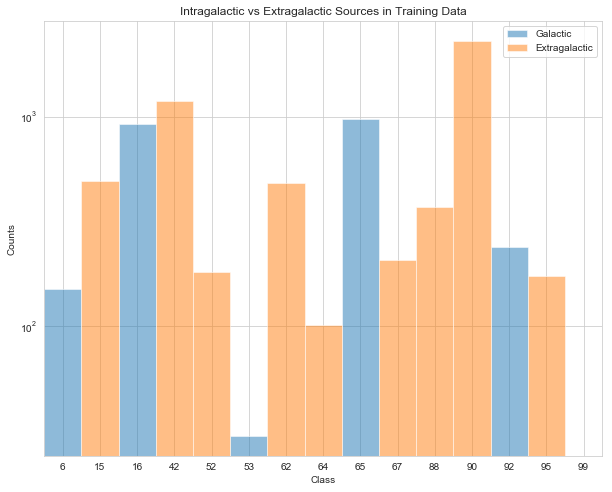

In [3]:
# Galactic vs Extragalactic Code by Kyle Boone
# https://www.kaggle.com/kyleboone/naive-benchmark-galactic-vs-extragalactic

targets = np.hstack([np.unique(train_metadata['target']), [99]])
target_map = {j:i for i, j in enumerate(targets)}
target_ids = [target_map[i] for i in train_metadata['target']]
train_metadata['target_id'] = target_ids

# Intragalactic sources have no redshift! (hostgal_spez == 0)
intragalactic_cut = train_metadata['hostgal_specz'] == 0.
plt.figure(figsize=(10, 8))
plt.hist(train_metadata[intragalactic_cut]['target_id'], 15, (0, 15), alpha=0.5, label='Galactic')
plt.hist(train_metadata[~intragalactic_cut]['target_id'], 15, (0, 15), alpha=0.5, label='Extragalactic')
plt.xticks(np.arange(15)+0.5, targets)
plt.gca().set_yscale("log")
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim(0, 15)
plt.title('Intragalactic vs Extragalactic Sources in Training Data')
plt.legend();

Another point of interest is that Class 99 (the unknown classification) is not present at all in the training dataset.  This raises a serious problem:  How to predict this mystery class when it is not represented at all in the training data?  While predicting Class 99 is not necessary for the limited scope of this report (our test data is split from the training dataset using `sklearn.model_selection.StratifiedKFold`), it nonetheless gives us an appreciation for the real difficulty of this competition.  The problem is further compounded by another challenging aspect of the competition, that the training dataset is a small subset of the test dataset and also a poor representation of it.  This design decision was made to imitate the real-world challenges that astronomers face when trying to classify cosmological objects.

## Exploratory Visualization

It is helpful to look at the example passband data for the various classes to get an understanding of what the data looks like and understand some of the distinguishing features between classes.  As there are 14 classes represented in the training dataset, we will only examine two of the more interesting classes: Class 92 and Class 42.  Class 92 are highly periodic while Class 42 exhibit what appear to be "burst" events with diminishing activity afterwards.  The author of the code that produced this visualization, [Mithrillion](https://www.kaggle.com/mithrillion), theorizes that Class 92 are regular variable stars and Class 42 are supernovae events [[4](#references)].

In [4]:
# Visualization Code by Mithrillion
# https://www.kaggle.com/mithrillion/all-classes-light-curve-characteristics-updated

groups = train_series.groupby(['object_id', 'passband'])
times = groups.apply(
    lambda block: block['mjd'].values).reset_index().rename(columns={0: 'seq'})
flux = groups.apply(
    lambda block: block['flux'].values
).reset_index().rename(columns={0: 'seq'})
err = groups.apply(
    lambda block: block['flux_err'].values
).reset_index().rename(columns={0: 'seq'})
det = groups.apply(
    lambda block: block['detected'].astype(bool).values
).reset_index().rename(columns={0: 'seq'})
times_list = times.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
flux_list = flux.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
err_list = err.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
det_list = det.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()

def fit_multiband_freq(tup):
    idx, group = tup
    t, f, e, b = group['mjd'], group['flux'], group['flux_err'], group['passband']
    model = LombScargleMultiband(fit_period=True)
    model.optimizer.period_range = (0.1, int((group['mjd'].max() - group['mjd'].min()) / 2))
    model.fit(t, f, e, b)
    return model

def get_freq_features(N, subsetting_pos=None):
    if subsetting_pos is None:
        subset_times_list = times_list
        subset_flux_list = flux_list
    else:
        subset_times_list = [v for i, v in enumerate(times_list) 
                             if i in set(subsetting_pos)]
        subset_flux_list = [v for i, v in enumerate(flux_list) 
                            if i in set(subsetting_pos)]
    feats = featurize.featurize_time_series(times=subset_times_list[:N],
                                            values=subset_flux_list[:N],
                                            features_to_use=['skew',
                                                            'percent_beyond_1_std',
                                                            'percent_difference_flux_percentile'
                                                            ],
                                            scheduler=None)
    subset = train_series[train_series['object_id'].isin(
        train_metadata['object_id'].iloc[subsetting_pos].iloc[:N])]
    models = list(map(fit_multiband_freq, subset.groupby('object_id')))
    feats['object_pos'] = subsetting_pos[:N]
    feats['freq1_freq'] = [model.best_period for model in models]
    return feats, models

unique_classes = train_metadata['target'].unique()

def get_class_feats(label, N=10):
    class_pos = train_metadata[train_metadata['target'] == label].index
    class_feats, class_models = get_freq_features(N, class_pos)
    return class_feats, class_models

def plot_phase_curves(feats, models, use_median_freq=False, hide_undetected=True, N=10):
    for i in range(N):
        freq = feats.loc[i, 'freq1_freq'].median()
        freq_min = feats.loc[i, 'freq1_freq'].min()
        freq_std = feats.loc[i, 'freq1_freq'].std()
        skew = feats.loc[i, 'skew'].mean()
        object_pos = int(feats.loc[i, 'object_pos'][0])
        f, ax = plt.subplots(1, 2, figsize=(14, 4))
        sample = train_series[train_series['object_id'] ==
                              train_metadata['object_id'].iloc[object_pos]].copy()
        colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
        score = models[i].score(models[i].best_period)
        
        ax[0].scatter(x=sample['mjd'], 
                   y=sample['flux'], 
                   c=[colors[b] for b in sample['passband']],
                   s=8, alpha=0.8)
        ax[0].vlines(sample['mjd'], 
                  sample['flux'] - sample['flux_err'],
                  sample['flux'] + sample['flux_err'],
                  colors=[colors[b] for b in sample['passband']],
                  linewidth=1, alpha=0.8)
        
        sample['phase'] = (sample['mjd'] / models[i].best_period) % 1
        ax[1].scatter(x=sample['phase'], 
                   y=sample['flux'], 
                   c=[colors[b] for b in sample['passband']],
                   s=8, alpha=0.8)
        ax[1].vlines(sample['phase'], 
                  sample['flux'] - sample['flux_err'],
                  sample['flux'] + sample['flux_err'],
                  colors=[colors[b] for b in sample['passband']],
                  linewidth=1, alpha=0.8)
        x_range = np.linspace(sample['mjd'].min(), sample['mjd'].max(), 1000)
        for band in range(6):
            y = models[i].predict(x_range, band)
            xs = (x_range / models[i].best_period) % 1
            ords = np.argsort(xs)
            ax[1].plot(xs[ords], y[ords], c=colors[band], alpha=0.4)
        
        title = ax[0].get_title()
        ax[0].set_title('time')
        ax[1].set_title('phase')
        f.suptitle(title + f'object: {sample["object_id"].iloc[0]}, '
                   f'class: {train_metadata["target"].iloc[object_pos]}\n'
                   f'period: {models[i].best_period: .4}, '
                   f'period score: {score: .4}, '
                   f'mean skew: {skew:.4}', y=1.1)
        plt.show()

In [5]:
%%capture capt
feats, models = get_class_feats(92)

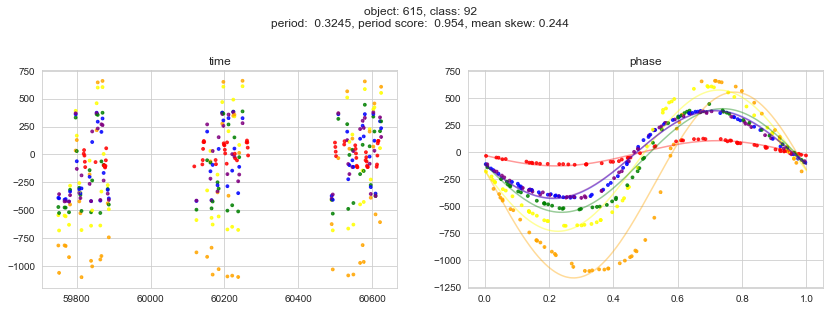

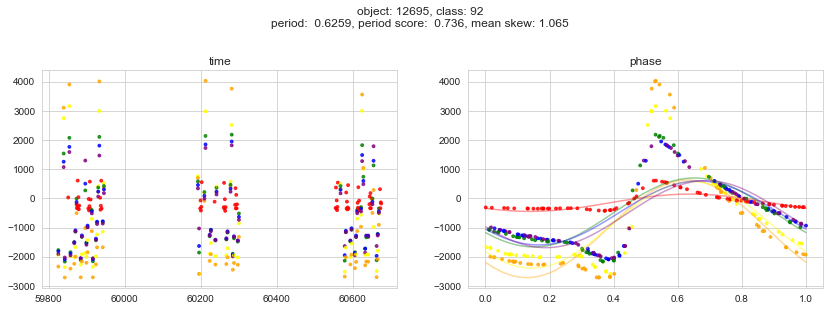

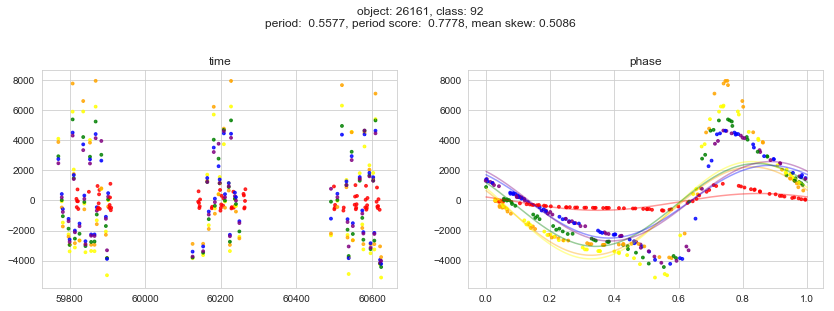

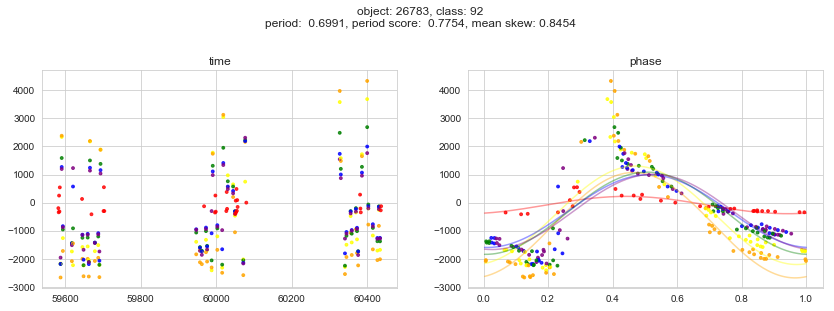

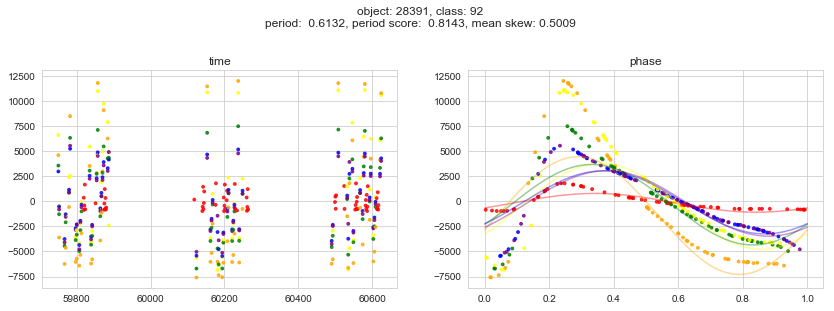

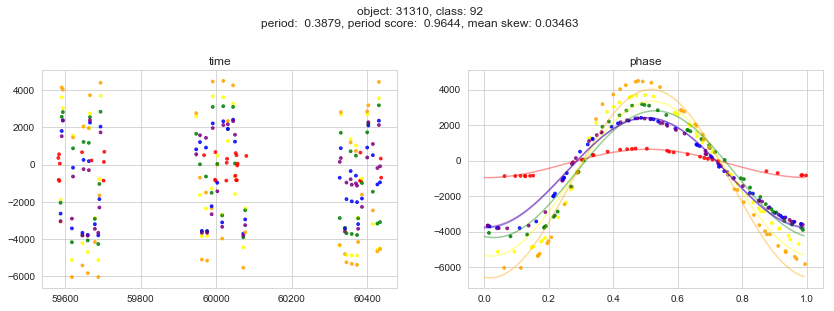

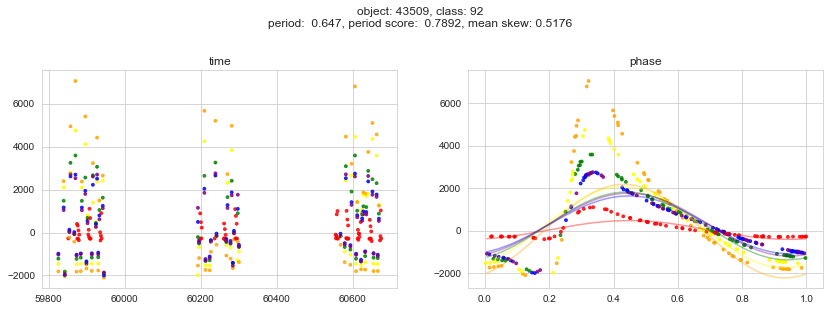

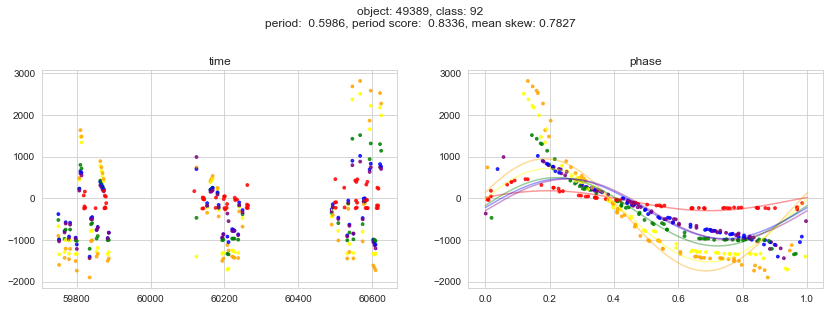

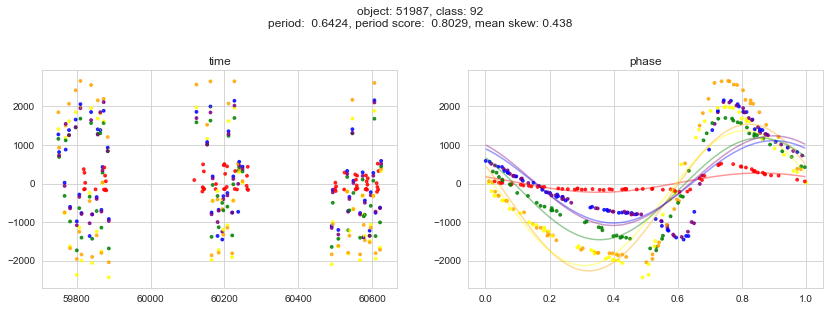

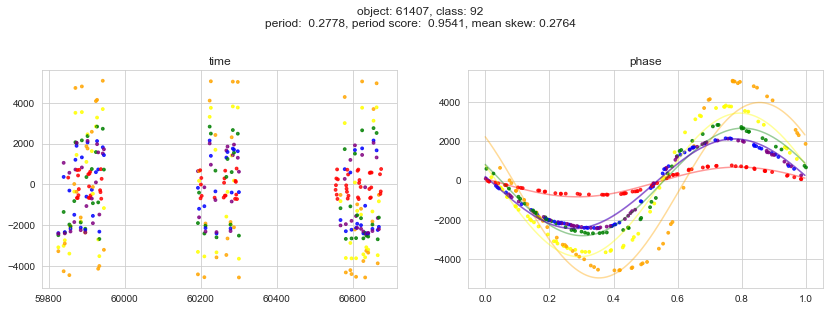

In [6]:
plot_phase_curves(feats, models)

In [7]:
%%capture capt
feats, models = get_class_feats(42)

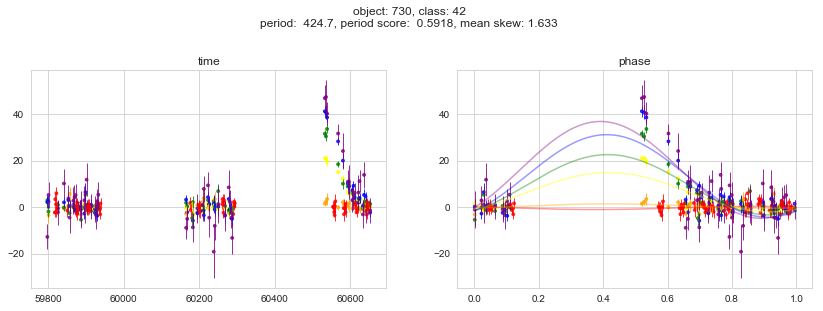

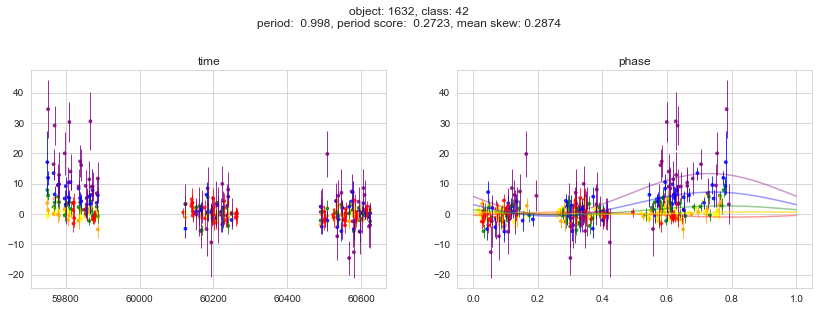

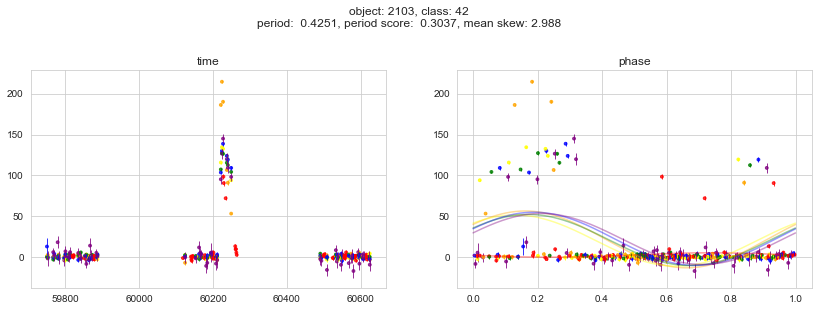

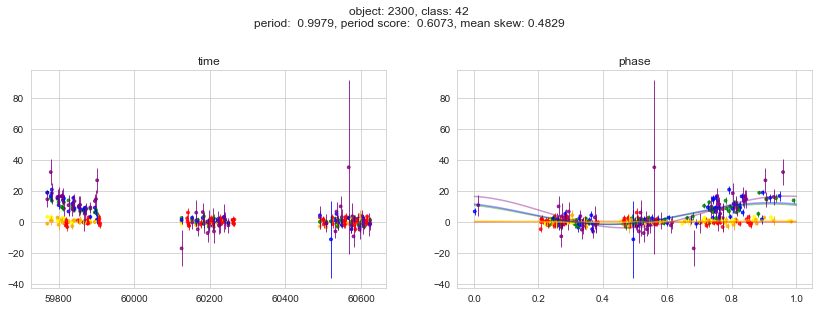

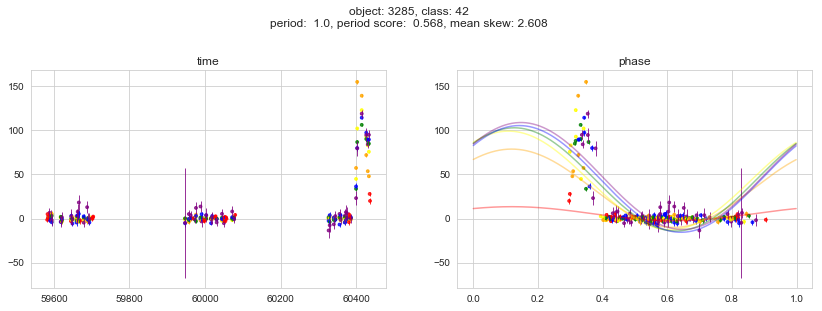

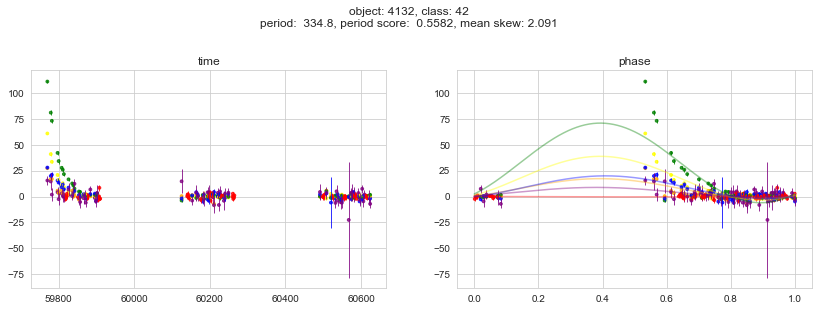

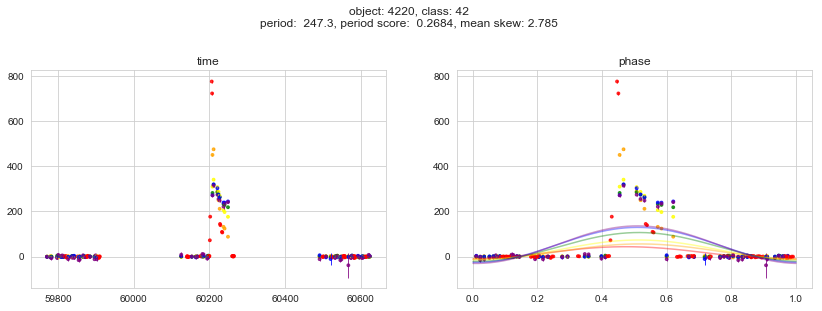

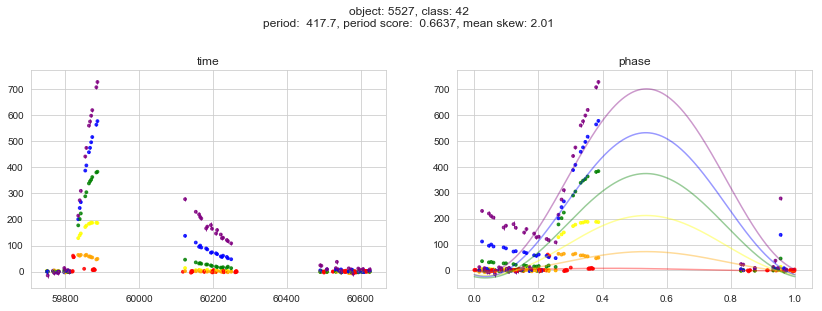

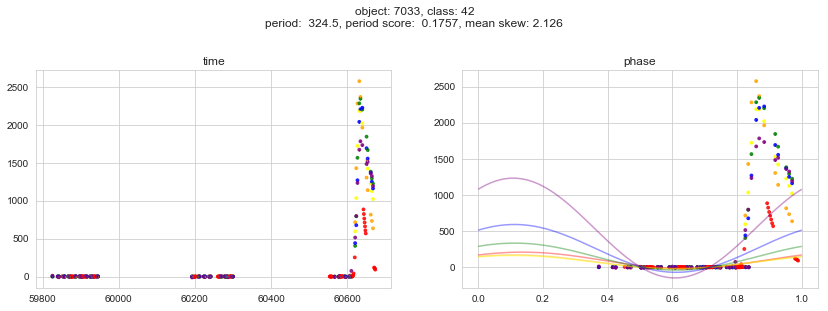

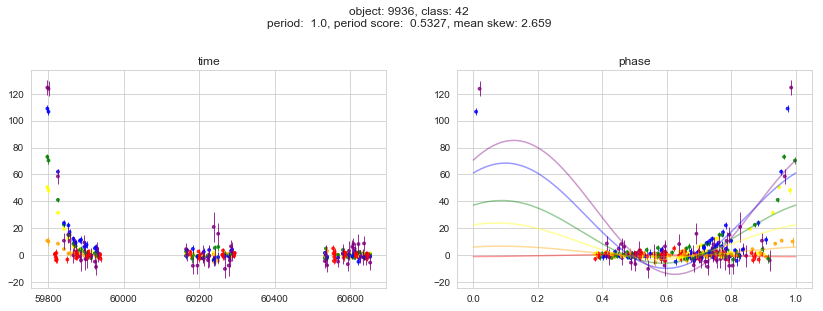

In [8]:
plot_phase_curves(feats, models)

## Benchmark

The [demo classifier](https://www.kaggle.com/michaelapers/the-plasticc-astronomy-classification-demo) provided by the PLAsTiCC team was designed as follows:

1. The raw tabular data is converted into a form suitable for analysis.  Using the **cesium** package for Python, **Timeseries** objects are constructed for each light curve.
2. The data is split into a training and test set.
3. The dimensionality of the training data is reduced using Principle Component Analysis (PCA).  The result of this step are features which are linear combinations of the passband data.  With just eight (8) features, we can account for almost all of the explained variance.
4. The reduced training dataset is fit with a Random Forest Classifier and predictions are obtained for the test dataset.

# PLAsTiCC Prediction Pipeline

Using [Higepon's CNN based model](https://www.kaggle.com/higepon/keras-cnn-use-time-series-data-as-is) as a starting point [[5](#references)], we design a prediction pipeline as follows:

1. Data Preprocessing: time series features for each object are scaled to unit variance.
2. Partitioning Intragalactic and Extragalactic Sources: the entire dataset is split into two segments based upon whether or not the spectroscopic redshift equals 0 (intragalactic) or not (extragalactic).
3. Data Transformation: the time series data for each object is transformed into a two dimensional monotone image which can be provided as input to a CNN.
4. CNN Model Implementation: Two separate CNN models are created and trained on the intragalactic and extragalactic datasets.

## Data Preprocessing

The data for this challenge has been provided in a curated form by the PLAsTiCC Team.  As such most data preprocessing techniques, like defaulting missing data values or one-hot encoding text categories, are not required for our pipeline.  We do make use of `sklearn.preprocessing.StandardScaler` to standardize the time-series features (`mjd`, `flux`, and `flux_err`).  Standardizing means removing the mean and scaling the feature to unit variance [[6](#references)].  This is helpful for CNN training.

In [9]:
# Standardize Time-Series Data

scaler = StandardScaler()
train_series[['mjd', 'flux', 'flux_err']] = scaler.fit_transform(train_series[['mjd', 'flux', 'flux_err']])
train_series = train_series.sort_values(['object_id', 'passband', 'mjd'])
train_series.head()

,object_id,mjd,passband,flux,flux_err,detected
54,615,-1.164326,0,-0.004834,-0.005730,0
55,615,-1.161249,0,0.003983,-0.005692,1
56,615,-1.158022,0,-0.009529,-0.005588,0
57,615,-1.154763,0,-0.024474,-0.005538,1
58,615,-1.151400,0,-0.037464,-0.005616,1


## Partitioning Intragalactic and Extragalactic Sources

As seen in the Data Exploration section, we can narrow number of possible classifications to 5 out of 14 possibilities for galactic sources and 9 out of 14 possibilities for extragalactic sources.  It makes sense to partition our data along these lines and train two separate CNN's for each category.  In this manner, we can reduce the number of erroneous classifications for each model.

The determination for whether a source is intragalactic or extragalactic is done using the `hostgal_specz` field in the training metadata.  This field represents the spectroscopic redshift of the source and it will (effectively) equal 0 for intragalactic sources.

In [10]:
# Partition the Training Data (Intragalactic vs. Extragalactic)

intragal_metadata = train_metadata[train_metadata['hostgal_specz'] == 0.]
intragal_series = train_series[np.in1d(train_series['object_id'], intragal_metadata['object_id'])]

extragal_metadata = train_metadata[train_metadata['hostgal_specz'] != 0.]
extragal_series = train_series[np.in1d(train_series['object_id'], extragal_metadata['object_id'])]

print('Length of Intragalactic Metadata: ', len(intragal_metadata))
print('Length of Extragalactic Metadata: ', len(extragal_metadata))

Length of Intragalactic Metadata:  2325
Length of Extragalactic Metadata:  5523


# Data Transformation

CNN's are commonly used for classifying visual images which are two-dimensional, so we should convert our data into a form that is appropriate for this model.  Using the time series data for each object, we construct a monotone image with width of size  `len(flux) + len(flux_err) + len(detected)` and height of size `# of passbands`.  The "images" for all objects are used for training the CNN and making predictions.

The general steps for doing the 2-D transformation are to:

- Group the time-series data (flux, flux_err, detected) by passband per object
- Take the Matrix Tranpose (m x n) => (n x m)
- Extract object labels for the passband == 0 row for each object

In [31]:
# Group Flux, Flux-Err, and Detected Data by Passband for each Object

train_intragal_timeseries = intragal_series.groupby(['object_id', 'passband'])['flux', 'flux_err', 'detected'].apply(lambda df: df.reset_index(drop=True)).unstack()
train_intragal_timeseries.fillna(0, inplace=True)
train_intragal_timeseries.columns = ['_'.join(map(str,tup)).rstrip('_') for tup in train_intragal_timeseries.columns.values]

train_extragal_timeseries = extragal_series.groupby(['object_id', 'passband'])['flux', 'flux_err', 'detected'].apply(lambda df: df.reset_index(drop=True)).unstack()
train_extragal_timeseries.fillna(0, inplace=True)
train_extragal_timeseries.columns = ['_'.join(map(str,tup)).rstrip('_') for tup in train_extragal_timeseries.columns.values]
train_extragal_timeseries.head(7)

flux_0    flux_1    flux_2    flux_3    flux_4  \
object_id passband                                                     
713       0        -0.004728 -0.005569 -0.005976 -0.006797 -0.006067   
          1        -0.004634 -0.005851 -0.005095 -0.005898 -0.007304   
          2        -0.004228 -0.005356 -0.004944 -0.005630 -0.005632   
          3        -0.004889 -0.005043 -0.005259 -0.005406 -0.006830   
          4        -0.005285 -0.004452 -0.005430 -0.005597 -0.004515   
          5        -0.003427 -0.004072 -0.004822 -0.006350 -0.009233   
730       0        -0.007336 -0.005783 -0.007306 -0.006386 -0.005088   

                      flux_5    flux_6    flux_7    flux_8    flux_9  \
object_id passband                                                     
713       0        -0.005670 -0.005371 -0.006339 -0.005826 -0.002763   
          1        -0.006275 -0.005897 -0.005519 -0.006236 -0.005691   
          2        -0.006326 -0.005777 -0.005650 -0.005862 -0.005340   
          3        -0.006312 -0.005996 -0.005900 -0.006008 -0.003977   
          4        -0.005262 -0.005939 -0.005855 -0.006131 -0.005082   
          5        -0.006061 -0.005859 -0.005612 -0.005130 -0.004306   
730       0        -0.006750 -0.007100 -0.006589 -0.007298 -0.007496   

                       ...       detected_62  detected_63  detected_64  \
object_id passband     ...                                               
713       0            ...               0.0          0.0          1.0   
          1            ...               0.0          0.0          0.0   
          2            ...               0.0          0.0          0.0   
          3            ...               0.0          0.0          0.0   
          4            ...               0.0          0.0          0.0   
          5            ...               0.0          0.0          0.0   
730       0            ...               0.0          0.0          0.0   

                    detected_65  detected_66  detected_67  detected_68  \
object_id passband                                                       
713       0                 0.0          1.0          1.0          0.0   
          1                 0.0          0.0          0.0          0.0   
          2                 0.0          0.0          0.0          0.0   
          3                 0.0          0.0          0.0          0.0   
          4                 0.0          0.0          0.0          0.0   
          5                 0.0          0.0          0.0          0.0   
730       0                 0.0          0.0          0.0          0.0   

                    detected_69  detected_70  detected_71  
object_id passband                                         
713       0                 0.0          0.0          0.0  
          1                 0.0          0.0          0.0  
          2                 0.0          0.0          0.0  
          3                 0.0          0.0          0.0  
          4                 0.0          0.0          0.0  
          5                 0.0          0.0          0.0  
730       0                 0.0          0.0          0.0  

[7 rows x 216 columns]

In [32]:
# Calculate the Number of Columns (should be the same for both Intragalactic and Extragalactic)

num_columns_intragal = len(train_intragal_timeseries.columns)
num_columns_extragal = len(train_extragal_timeseries.columns)
print('Number of Columns for Intragalactic Time Series Data: ', num_columns_intragal)
print('Number of Columns for Extragalactic Time Series Data: ', num_columns_extragal)

Number of Columns for Intragalactic Time Series Data:  216
Number of Columns for Extragalactic Time Series Data:  216


In [33]:
# Reshape the Time Series Data and Matrix Transpose (m x n) => (n x m)

X_intragal_train = train_intragal_timeseries.values.reshape(-1, 6, num_columns_intragal).transpose(0, 2, 1)
X_extragal_train = train_extragal_timeseries.values.reshape(-1, 6, num_columns_extragal).transpose(0, 2, 1)

In [34]:
# Create Unique Class Dictionaries for the Datasets

intragal_classes = sorted(intragal_metadata.target.unique())
class_intragal_map = dict()
for i,val in enumerate(intragal_classes):
    class_intragal_map[val] = i

extragal_classes = sorted(extragal_metadata.target.unique())
class_extragal_map = dict()
for i,val in enumerate(extragal_classes):
    class_extragal_map[val] = i

print('Intragalactic Classes Dictionary: ', class_intragal_map)
print('Extragalactic Classes Dictionary: ', class_extragal_map)

Intragalactic Classes Dictionary:  {6: 0, 16: 1, 53: 2, 65: 3, 92: 4}
Extragalactic Classes Dictionary:  {15: 0, 42: 1, 52: 2, 62: 3, 64: 4, 67: 5, 88: 6, 90: 7, 95: 8}


In [35]:
# In a separate data structure, remove Passband Rows so each Object corresponds to a single Row

train_intragal_timeseries0 = train_intragal_timeseries.reset_index()
train_intragal_timeseries0 = train_intragal_timeseries0[train_intragal_timeseries0.passband == 0]

train_extragal_timeseries0 = train_extragal_timeseries.reset_index()
train_extragal_timeseries0 = train_extragal_timeseries0[train_extragal_timeseries0.passband == 0]

train_extragal_timeseries0.head()

,object_id,passband,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,...,detected_62,detected_63,detected_64,detected_65,detected_66,detected_67,detected_68,detected_69,detected_70,detected_71
0,713,0,-0.004728,-0.005569,-0.005976,-0.006797,-0.006067,-0.005670,-0.005371,-0.006339,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6,730,0,-0.007336,-0.005783,-0.007306,-0.006386,-0.005088,-0.006750,-0.007100,-0.006589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,745,0,-0.006555,-0.006034,-0.006587,-0.007031,-0.005994,-0.005709,-0.006772,-0.006965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,1124,0,-0.006798,-0.005864,-0.007726,-0.006574,-0.008547,-0.006898,-0.006172,-0.006554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,1598,0,-0.007197,-0.006749,-0.007172,-0.008614,-0.006197,-0.007218,-0.006919,-0.006981,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Merge Time-Series and Object Metadata

merged_intragal_metadata = train_intragal_timeseries0.merge(intragal_metadata, on='object_id', how='left')
merged_intragal_metadata.fillna(0, inplace=True)

merged_extragal_metadata = train_extragal_timeseries0.merge(extragal_metadata, on='object_id', how='left')
merged_extragal_metadata.fillna(0, inplace=True)

In [37]:
# Extract Object Labels

y_intragal = merged_intragal_metadata.target
classes_intragal = sorted(y_intragal.unique())

y_extragal = merged_extragal_metadata.target
classes_extragal = sorted(y_extragal.unique())

targets_intragal = merged_intragal_metadata.target
target_intragal_map = np.zeros((targets_intragal.shape[0],))
target_intragal_map = np.array([class_intragal_map[val] for val in targets_intragal])
Y_intragal = to_categorical(target_intragal_map)

targets_extragal = merged_extragal_metadata.target
target_extragal_map = np.zeros((targets_extragal.shape[0],))
target_extragal_map = np.array([class_extragal_map[val] for val in targets_extragal])
Y_extragal = to_categorical(target_extragal_map)
Y_extragal.shape

(5523, 9)

In [38]:
# Model Accuracy Plotter Function

def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('Model Loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('Model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

## CNN Model Implementation

TODO

Our CNN architecture makes use of the following Keras layers:

- Conv1D: a convolutional layer where the linear algebra of weights and inputs occurs.
- Activation: a layer which normalizes outputs to a given range.  In our model, we use a ReLU (Rectified Linear Unit) activation function which clamps negative values to 0 and leaves positive values unaffected.
- MaxPooling: a layer which collects the outputs of the previous layer into a single neuron.
- BatchNormalization: a layer that normalizes the activations of the previous layer.
- Dropout: a layer that randomly sets a fraction of the inputs to 0 to permit all neurons to train, thereby reducing overfitting.
- Lambda: a Lambda layer which returns the average serves as a Global Average Pooling layer.  GAP layers are structural regularizers that prevens overfitting of the overall structure [[7](#references)].
- Dense: a Dense layer maps the data into the respective probabilities for each classification (shaped 5 for intragalactic, shaped 9 for extragalactic) using a *softmax* activation function.

The CNN architecture was designed as follows:



In [39]:
# Construct the CNN Architecture

batch_size = 256

def build_model(X_train, classes):
    input = Input(shape=(X_train.shape[1], 6), dtype='float32', name='input0')
    output = Conv1D(256,
                 kernel_size=160,
                 strides=4,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(input)
    output = Activation('relu')(output)
    output = Conv1D(256,
                 kernel_size=160,
                 strides=4,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(input)
    output = Activation('relu')(output)
    output = MaxPooling1D(pool_size=4, strides=None)(output)
    output = Conv1D(256,
                 kernel_size=160,
                 strides=4,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(input)
    output = Activation('relu')(output)
    output = Conv1D(256,
                 kernel_size=160,
                 strides=4,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(input)
    output = Activation('relu')(output)
    output = BatchNormalization()(output)
    output = Lambda(lambda x: K.mean(x, axis=1))(output) # Same as GAP for 1D Conv Layer
    output = Dropout(0.5, noise_shape=None, seed=None)(output)
    output = Dense(len(classes), activation='softmax')(output)
    model = Model(inputs=input, outputs=output)
    return model

# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

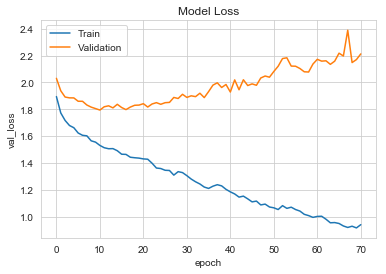

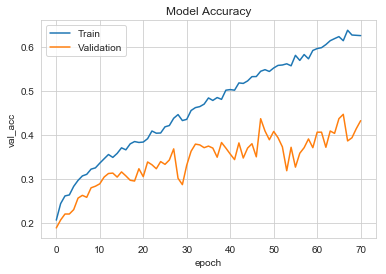

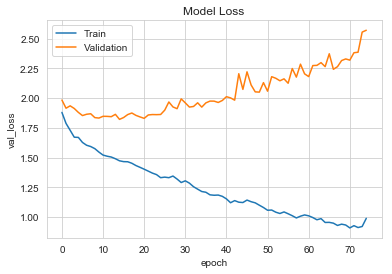

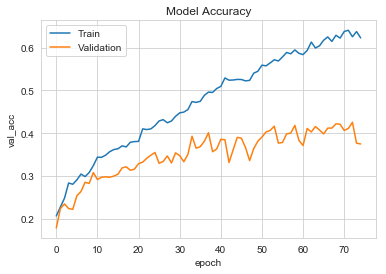

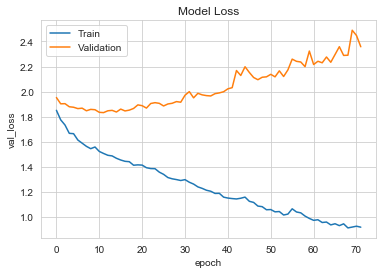

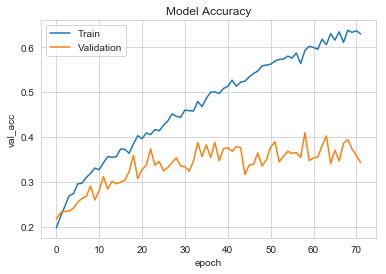

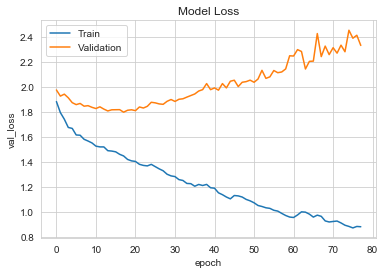

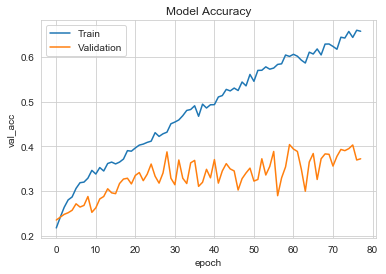

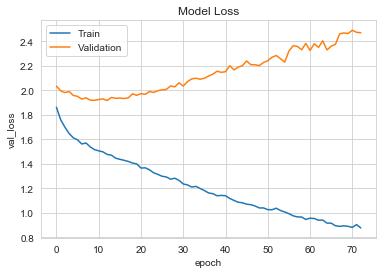

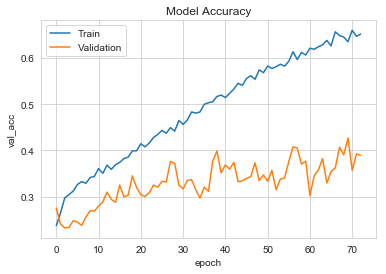

elapsed_time: 1125.512834072113


In [40]:
# Train the Extragalactic CNN Model and Run Predictions

epochs = 1000
y_extragal_count = Counter(target_extragal_map)
wtable = np.zeros((len(classes_extragal),))
for i in range(len(classes_extragal)):
    wtable[i] = y_extragal_count[i] / target_extragal_map.shape[0]

y_extragal_map = target_extragal_map
y_extragal_categorical = Y_extragal
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
start = time.time()
clfs_extragal = []
oof_extragal_preds = np.zeros((len(X_extragal_train), len(classes_extragal)))

model_extragal_file = "model_extragal.weights"

for fold_, (trn_, val_) in enumerate(folds.split(y_extragal_map, y_extragal_map)):
    checkPoint = ModelCheckpoint(model_extragal_file, monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)

    x_extragal_train, y_extragal_train = X_extragal_train[trn_], Y_extragal[trn_]
    x_extragal_valid, y_extragal_valid = X_extragal_train[val_], Y_extragal[val_]

    model_extragal = build_model(X_extragal_train, classes_extragal)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    stopping = EarlyStopping(monitor='val_loss', patience=60, verbose=0, mode='auto')

    model_extragal.compile(loss=mywloss, optimizer=optimizer, metrics=['accuracy'])
    history_extragal = model_extragal.fit(
        x_extragal_train, y_extragal_train,
        validation_data=[x_extragal_valid, y_extragal_valid],
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False, verbose=0, callbacks=[checkPoint, stopping])
    plot_loss_acc(history_extragal)
    model_extragal.load_weights(model_extragal_file)
    # Get predicted probabilities for each class
    oof_extragal_preds[val_, :] = model_extragal.predict(x_extragal_valid, batch_size=batch_size)
    clfs_extragal.append(model_extragal)

elapsed_time = time.time() - start
print("elapsed_time:", elapsed_time)

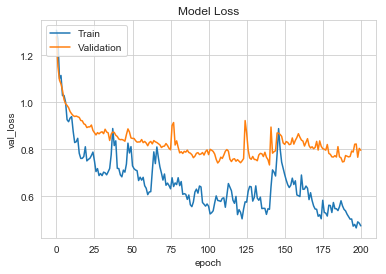

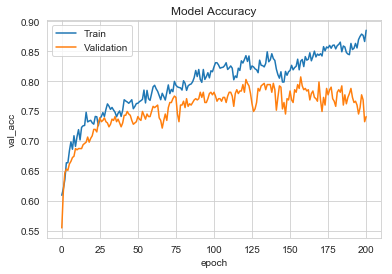

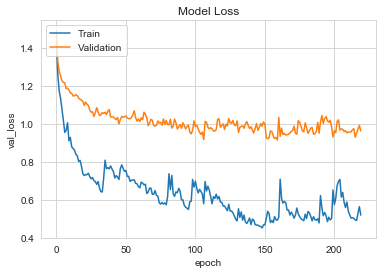

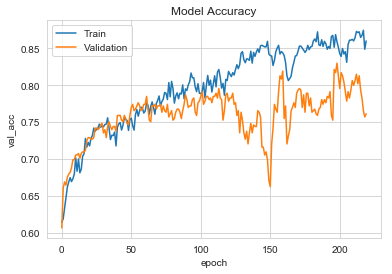

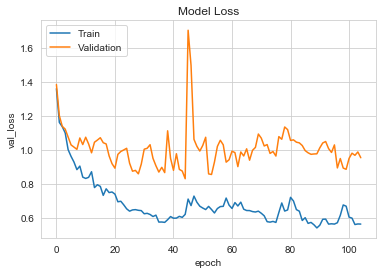

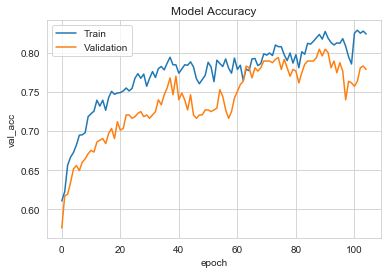

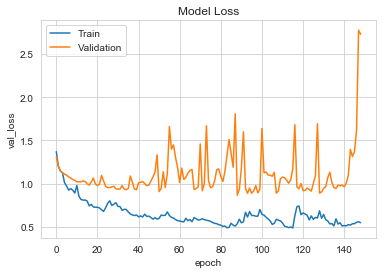

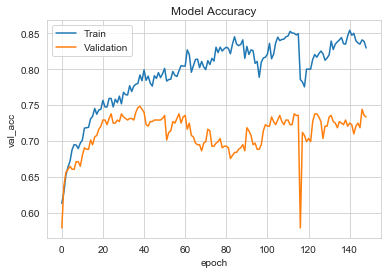

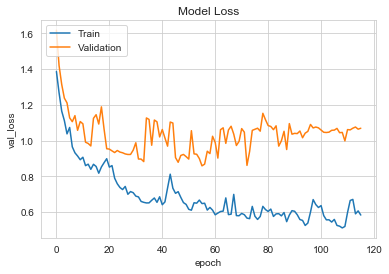

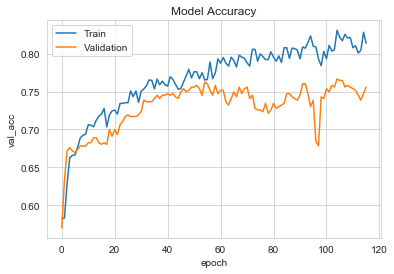

elapsed_time: 1002.7361378669739


In [41]:
# Train the Intragalactic CNN Model and Run Predictions

epochs = 1000
y_intragal_count = Counter(target_intragal_map)
wtable = np.zeros((len(classes_intragal),))
for i in range(len(classes_intragal)):
    wtable[i] = y_intragal_count[i] / target_intragal_map.shape[0]

y_intragal_map = target_intragal_map
y_intragal_categorical = Y_intragal
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
start = time.time()
clfs_intragal = []
oof_intragal_preds = np.zeros((len(X_intragal_train), len(classes_intragal)))

model_intragal_file = "model_intragal.weights"

for fold_, (trn_, val_) in enumerate(folds.split(y_intragal_map, y_intragal_map)):
    checkPoint = ModelCheckpoint(model_intragal_file, monitor='val_loss', mode = 'min', save_best_only=True, verbose=0)

    x_intragal_train, y_intragal_train = X_intragal_train[trn_], Y_intragal[trn_]
    x_intragal_valid, y_intragal_valid = X_intragal_train[val_], Y_intragal[val_]

    model_intragal = build_model(X_intragal_train, classes_intragal)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    stopping = EarlyStopping(monitor='val_loss', patience=60, verbose=0, mode='auto')

    model_intragal.compile(loss=mywloss, optimizer=optimizer, metrics=['accuracy'])
    history_intragal = model_intragal.fit(
        x_intragal_train, y_intragal_train,
        validation_data=[x_intragal_valid, y_intragal_valid],
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False, verbose=0, callbacks=[checkPoint, stopping])
    plot_loss_acc(history_intragal)
    model_intragal.load_weights(model_intragal_file)
    # Get predicted probabilities for each class
    oof_intragal_preds[val_, :] = model_intragal.predict(x_intragal_valid, batch_size=batch_size)
    clfs_intragal.append(model_intragal)

elapsed_time = time.time() - start
print("elapsed_time:", elapsed_time)

In [42]:
# Compile Model Results

Y_pred = []
Y_test = []
classes = [53, 64, 6, 95, 52, 67, 92, 88, 62, 15, 16, 65, 42, 90]

def convert_sub_class_to_full_class_prob(arr):
    if len(arr) == 5:
        return np.array([arr[2], 0., arr[0], 0., 0., 0., arr[4], 0., 0., 0., arr[1], arr[3], 0., 0.])
    elif len(arr) == 9:
        return np.array([0., arr[4], 0., arr[8], arr[2], arr[5], 0., arr[6], arr[3], arr[0], 0., 0., arr[1], arr[7]])
    else:
        return np.array([])

def convert_full_class_prob_to_class_pred(arr):
    max_index = arr.argmax(axis=0)
    return classes[max_index]

for pred in oof_intragal_preds:
    full_class_pred = convert_sub_class_to_full_class_prob(pred)
    Y_pred.append(convert_full_class_prob_to_class_pred(full_class_pred))
for pred in oof_extragal_preds:
    full_class_pred = convert_sub_class_to_full_class_prob(pred)
    Y_pred.append(convert_full_class_prob_to_class_pred(full_class_pred))

for target in y_intragal:
    Y_test.append(target)
for target in y_extragal:
    Y_test.append(target)

# Results

## Model Evaluation

The summary of the architecture for one of the CNN's is shown below.  Here the input is a (216 x 6) matrix where 216 is `len(flux) + len(flux_err) + len(detected)` and 6 is the number of passbands.  The final model has a total of 249,353 parameters with 246,016 of those being in the convolutional layers, 1024 in batch normalization layers, and 2313 in the dense layer that produces the predictions.  Of these parameters, 512 are non-trainable.  The model trains in 2,128 seconds (35.46 minutes).

In [43]:
model_extragal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input0 (InputLayer)          (None, 216, 6)            0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 54, 256)           246016    
_________________________________________________________________
activation_60 (Activation)   (None, 54, 256)           0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 54, 256)           1024      
_________________________________________________________________
lambda_25 (Lambda)           (None, 256)               0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 9)                 2313      
Total para

## Model Validation

TODO

Some type of analysis is used to validate the robustness of the model’s solution

## Justification

Our CNN-based model yields the following confusion matrix with an average prediction accuracy per label of 0.546.  This is only 5.4% better than the demo classifer's score of 0.518, which isn't meaningfully enough to declare it a better solution.  Furthermore, it required 35 minutes of training compared to the demo classifier notebook which ran in under 5 minutes.  As such, I would not consider it to have adequately solved the problem.

```
(0.90 + 0.82 + 0.62 + 0.38 + 0.15 +
 0.39 + 0.86 + 0.72 + 0.32 + 0.62 +
 0.73 + 0.79 + 0.09 + 0.26) / 14
= 0.546
```

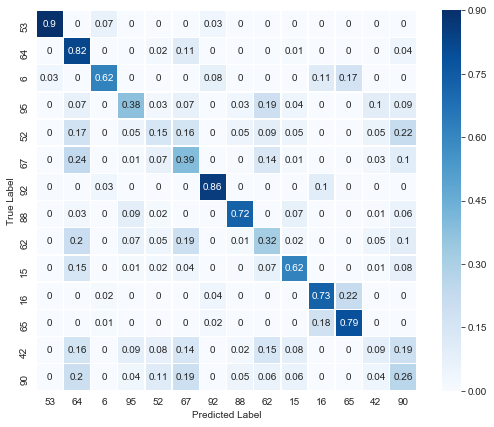

In [44]:
# Construct CNN Model Confusion Matrix

counts = Counter(train_metadata['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))

cm = confusion_matrix(Y_test, Y_pred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

# Conclusion

## Reflection

The PLAsTiCC competition has been challenging for me on many levels.  Even with the example kernels available on Kaggle, it was difficult to get started because the data was structured in a more complicated manner than anything I had previously worked with.  Specifically, we have object metadata in one CSV file and time series data for the objects in another.  Whereas with the object metadata, the relationship between object to row is one to one, with the time-series data it is one to many.  Transforming the time-series data into a workable form required grouping it and merging it with the metadata.  I found that these steps of the programming were the most arduous.

Optimizing the CNN architecture was another challenge because it was time-consuming.  Whereas it was fun to anticipate the model's accuracy after a long training run, it was also frequently disheartening.  This was especially true when there were bugs and typo's in the code that aborted a training run, which I didn't realize it until returning from a coffee break.

Lastly, although outside of the scope of this report, I gained an appreciation for the true complexity of the competition itself.  Firstly, we are given a training set which is a tiny subset of the test data and is also a bad representation of it.  This design choice was made to simulate the challenge astronomers will face when they begin analyzing the LSST dataset which will dwarf any currently available telescopic data.  Secondly, the test data includes a new class not present in the training data: Class 99.  This design choice was made to represent the new cosmological sources that astronomers expect to find when they begin analyzing the LSST data.  Taken together, these two points pose an incredibly difficult problem for us competitors: How can we create a model that identifies this mystery class in the test data when we have such a limited training dataset which doesn't include it in the first place?

The approaches I have seen for solving this have been quite creative.  One way is to assign a constant prediction (e.g. 0.2) to Class 99 so that the model must have at least that much confidence in a different class in order to pick it.  However, this is reported to too heavily bias Class 99.  Another approach is to assign Class 99 a probability of `1 - max(other class probabilities)`. This again means that the model must have at least 50% confidence in another class in order to pick it.  This approach also is reported to over-bias Class 99.  Finally, one last approach is to assign Class 99 a probability equal to the product of the other class probabilities.  While I did not have a chance to approach this problem in the scope of the report, it is nonetheless interesting to see the varying ways people are approaching it.

## Improvement

I was disappointed with the result of the CNN-based model.  I expected that it would perform significantly better than the demo classifier, however the achieved results were statistically similar.  Moreover the CNN-based model required significantly more training time.  It was especially surprising that dividing the data between intragalactic and extragalactic sources did not improve results considering that this reduced the number of possible classifications each object could have.

We might be able to improve the model's accuracy by refining the CNN archiecture, which based on my own experimentations yielded accuracies between 0.471 and 0.546.  However, I am not convinced that this is a good route to investigate.  Instead, I would experiment with engineering more features or using a different type of neural network altogether.  Specifically a Long Short Term Memory (LSTM) Network could be utilized as it is more specialized for classifying time-series data [[8](#references)].  The challenge here is that the length of the time series data for the various objects is not uniform, which is a requirement for RNN's.  To workaround this we could pad the data with 0's to make it uniform, but this could cause other unintended consequences.

## Closing Remarks

![The Hierarchy of Variable and Transient Sources](https://github.com/danielbank/PLAsTiCC/blob/master/.github/variability_tree.jpg?raw=true)
**<center>Figure 5: The hierarchy of variable and transient sources. Credit: Laurent Eyer and Nami Mowlawi, Université de Genève</center>**

The tree diagram above illustrates every type of light source seen in the night sky that mankind currently knows about.  This tree is predicted to grow when the LSST comes online and begins collecting 20-40TB of light curve data every night.  The task of sifting through this enormous amount of data and finding those new types of light sources is impractical for humans but a perfect use case for machine learning.  Nonetheless, it is a huge technical challenge.  Finding those interesting sources whose light curve is different than the known classifications is like finding a needle in a haystack.  In the nomenclature of PLAsTiCC, astronomers are trying to detect Class 99 in a huge test dataset with models trained on on a small training set that doesn't include it.

In this report, we focused on a test dataset split from the training dataset and attempted to develop a CNN-based classier that was more accurate than the PLAsTiCC demo classifier.  Our achieved accuracy was 0.546 which was 5.4% better than the demo classifier's accuracy of 0.518.  Unfortunately our classifier took over 7 times as long to train for that minimal improvement.

<a id='references'></a>

# References

[1] - [PLAsTiCC Astronomy Starter Kit](https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit)

[2] - [The PLAsTiCC Astronomy Classification Demo
](https://www.kaggle.com/michaelapers/the-plasticc-astronomy-classification-demo)

[3] - [Naive Benchmark - Galactic vs Extragalactic](https://www.kaggle.com/kyleboone/naive-benchmark-galactic-vs-extragalactic)

[4] - [All Classes Light Curve Characteristics](https://www.kaggle.com/mithrillion/all-classes-light-curve-characteristics-updated)

[5] - [Higepon's CNN-based Model for PLAsTiCC](https://www.kaggle.com/higepon/keras-cnn-use-time-series-data-as-is)

[6] - [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

[7] - [Network in Network](https://arxiv.org/pdf/1312.4400.pdf)

[8] - [Long short term memory](https://en.wikipedia.org/wiki/Long_short-term_memory)